<a href="https://colab.research.google.com/github/Has970211/U-Net-Implementation/blob/main/Original_UNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clone github repo

In [2]:
!git clone https://github.com/zhixuhao/unet.git

Cloning into 'unet'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 44.92 MiB | 18.96 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [3]:
cd unet/data/membrane/train

/content/unet/data/membrane/train


# Importatant libraries

In [4]:
import numpy as np 
import glob
from PIL import Image
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import imageio
import albumentations as albu
import os
from tqdm.auto import tqdm

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

In [1]:
!pip install -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2,ToTensor

     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 36.7MB 84kB/s 
     |████████████████████████████████| 952kB 57.5MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# DataLoader

## DataLoader class

In [85]:
class ISBIDataset(data.Dataset):
    def __init__(self, folder_path, transform=None, split='trainval'):   # initial logic happens like transform

        self.image_paths = glob.glob(os.path.join(folder_path,'image','*.png'))

        if split=='train':
            self.image_paths = self.image_paths[:25]
        elif split=='val':
            self.image_paths = self.image_paths[25:]

        self.label_paths = []
        # self.labels_paths = glob.glob(DATASET_PATH+'/_groundtruth_(1)_image_*.png')
        for img_path in self.image_paths:
          self.label_paths.append(os.path.join(folder_path,'label',os.path.basename(img_path)))


        assert len(self.image_paths)==len(self.label_paths)
        self.len = len(self.label_paths)
        print("Found %d images in the dataset"%(self.len ))

        self.transform = transform
        
    def __getitem__(self, idx):
        image = imageio.imread(self.image_paths[idx])
        mask = imageio.imread(self.label_paths[idx])

        if self.transform:
          transformed = self.transform(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]
          image.unsqueeze_(0)
          mask = F.pad(mask,(-92,-92,-92,-92))
        return image, mask

    def __len__(self):  
        return self.len


## Transforms 

In [71]:
NUM_CLASSES=2
train_transform = A.Compose([    
    A.Resize(width=388, height=388),
    A.PadIfNeeded(min_height=572,min_width=572, border_mode=2),
    A.Flip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(sigma=10),
    ToTensor(num_classes=NUM_CLASSES) 
])

val_transform = A.Compose([    
    A.Resize(width=388, height=388),
    A.PadIfNeeded(min_height=572,min_width=572, border_mode=2),
    ToTensor(num_classes=NUM_CLASSES) 
])

In [72]:
train_set=ISBIDataset("",transform=train_transform,split='train')
val_Set=ISBIDataset("", transform=val_transform,split='val')

Found 25 images in the dataset
Found 5 images in the dataset


In [73]:
BATCH_SIZE=4
train_loader    = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
val_loader      = data.DataLoader(val_Set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [74]:
for i, (inputs, labels) in enumerate(train_loader):
  print(inputs.size(), labels.size())
  if i > 10:
    break

torch.Size([4, 1, 572, 572]) torch.Size([4, 388, 388])
torch.Size([4, 1, 572, 572]) torch.Size([4, 388, 388])
torch.Size([4, 1, 572, 572]) torch.Size([4, 388, 388])
torch.Size([4, 1, 572, 572]) torch.Size([4, 388, 388])
torch.Size([4, 1, 572, 572]) torch.Size([4, 388, 388])
torch.Size([4, 1, 572, 572]) torch.Size([4, 388, 388])


# Original UNET Architecture

### **Unet Model Architecture**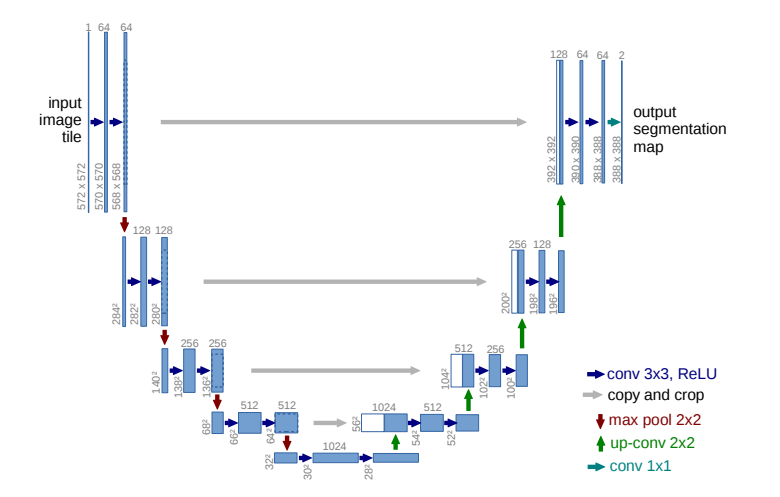

In [75]:
class Unet_original(nn.Module):
  def __init__(self):
    super(Unet_original, self).__init__()

    self.conv1 = nn.Conv2d(1, 64, 3, padding=0)
    nn.init.kaiming_normal_(self.conv1.weight)
    self.conv11 = nn.Conv2d(64, 64, 3, padding=0)
    nn.init.kaiming_normal_(self.conv11.weight)

    self.pool1 = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(64, 128, 3, padding=0)
    nn.init.kaiming_normal_(self.conv2.weight)
    self.conv22 = nn.Conv2d(128, 128, 3, padding=0)
    nn.init.kaiming_normal_(self.conv22.weight)

    self.conv3 = nn.Conv2d(128, 256, 3, padding=0)
    nn.init.kaiming_normal_(self.conv3.weight)
    self.conv33 = nn.Conv2d(256, 256, 3, padding=0)
    nn.init.kaiming_normal_(self.conv33.weight)

    self.conv4 = nn.Conv2d(256, 512, 3, padding=0)
    nn.init.kaiming_normal_(self.conv4.weight)
    self.conv44 = nn.Conv2d(512, 512, 3, padding=0)
    nn.init.kaiming_normal_(self.conv44.weight)

    self.drop1 = nn.Dropout(p=0.5)

    self.conv5 = nn.Conv2d(512, 1024, 3, padding=0)
    nn.init.kaiming_normal_(self.conv5.weight)
    self.conv55 = nn.Conv2d(1024, 1024, 3, padding=0)
    nn.init.kaiming_normal_(self.conv55.weight)

    self.up1 = nn.Upsample(scale_factor=2)

    self.uconv6 = nn.Conv2d(1024, 512, 2, padding=(1,1), dilation=2)
    nn.init.kaiming_normal_(self.uconv6.weight)

    self.conv6 = nn.Conv2d(1024, 512, 3, padding=0)
    nn.init.kaiming_normal_(self.conv6.weight)
    self.conv66 = nn.Conv2d(512, 512, 3, padding=0)
    nn.init.kaiming_normal_(self.conv66.weight)

    self.uconv7 = nn.Conv2d(512, 256, 2, padding=(1,1), dilation=2)
    nn.init.kaiming_normal_(self.uconv7.weight)

    self.conv7 = nn.Conv2d(512, 256, 3, padding=0)
    nn.init.kaiming_normal_(self.conv7.weight)
    self.conv77 = nn.Conv2d(256, 256, 3, padding=0)
    nn.init.kaiming_normal_(self.conv77.weight)

    self.uconv8 = nn.Conv2d(256, 128, 2, padding=(1,1), dilation=2)
    nn.init.kaiming_normal_(self.uconv8.weight)

    self.conv8 = nn.Conv2d(256, 128, 3, padding=0)
    nn.init.kaiming_normal_(self.conv8.weight)
    self.conv88 = nn.Conv2d(128, 128, 3, padding=0)
    nn.init.kaiming_normal_(self.conv88.weight)

    self.uconv9 = nn.Conv2d(128, 64, 2, padding=(1,1), dilation=2)
    nn.init.kaiming_normal_(self.uconv6.weight)

    self.conv9 = nn.Conv2d(128, 64, 3, padding=0)
    nn.init.kaiming_normal_(self.conv9.weight)
    self.conv99 = nn.Conv2d(64, 64, 3, padding=0)
    nn.init.kaiming_normal_(self.conv99.weight)

    self.conv10 = nn.Conv2d(64, 2, 1)
    nn.init.kaiming_normal_(self.conv10.weight)
    # self.conv1010 = nn.Conv2d(2, 1, 1)
    # nn.init.kaiming_normal_(self.conv1010.weight)    


  def forward(self, x):
    x1 = F.relu(self.conv1(x))
    x1 = F.relu(self.conv11(x1))
    p1 = self.pool1(x1)
    x2 = F.relu(self.conv2(p1))
    x2 = F.relu(self.conv22(x2))
    p2 = self.pool1(x2)
    x3 = F.relu(self.conv3(p2))
    x3 = F.relu(self.conv33(x3))
    p3 = self.pool1(x3)
    x4 = F.relu(self.conv4(p3))
    d4 = self.drop1(F.relu(self.conv44(x4)))
    x5 = self.pool1(d4)
    x5 = F.relu(self.conv5(x5))
    x5 = self.drop1(F.relu(self.conv55(x5)))

    #up
    u66 = self.up1(x5)
    u6 = F.relu(self.uconv6(u66))
    d4c = d4[:,:,4:-4,4:-4]
    #return x1.size(), p1.size(), x2.size(), p2.size(), x3.size(), p3.size(), x4.size(), d4.size(), x5.size(), u66.size(), u6.size()
    m6 = torch.cat((d4c, u6), 1)
    #return x1.size(), p1.size(), x2.size(), p2.size(), x3.size(), p3.size(), x4.size(), d4.size(), x5.size(), u66.size(), u6.size(), m6.size()
    m6 = F.relu(self.conv66(F.relu(self.conv6(m6))))

    u7 = F.relu(self.uconv7(self.up1(m6)))
    x3c = x3[:,:,16:-16,16:-16]
    m7 = torch.cat((x3c, u7), 1)
    m7 = F.relu(self.conv77(F.relu(self.conv7(m7))))

    u8 = F.relu(self.uconv8(self.up1(m7)))
    x2c = x2[:,:,40:-40,40:-40]
    m8 = torch.cat((x2c, u8), 1)
    m8 = F.relu(self.conv88(F.relu(self.conv8(m8))))

    u9 = F.relu(self.uconv9(self.up1(m8)))
    x1c = x1[:,:,88:-88,88:-88]
    m9 = torch.cat((x1c, u9), 1)
    m9 = F.relu(self.conv99(F.relu(self.conv9(m9))))

    x9 = self.conv10(m9)
    
    return x9


# Training

## Evaluator

In [76]:
class Evaluator(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.confusion_matrix = np.zeros((self.num_classes,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_classes)
        label = self.num_classes * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_classes**2)
        confusion_matrix = count.reshape(self.num_classes, self.num_classes)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_classes,) * 2)

In [77]:
evaluator = Evaluator(num_classes = 2)

In [78]:
model = Unet_original()

In [79]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [80]:
model.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) #optimizer function

In [81]:
epoch = 0
num_epochs = 100

## Training loop

In [82]:
for epoch in range(num_epochs):
    print("Starting Epoch",epoch)

    train_loss = 0
    
    model.train() 
    for inputs, labels in tqdm(train_loader):
        
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        #inputs.unsqueeze_(1)
        #labels.squeeze_(1)
        #labels = F.pad(labels,(-92,-92,-92,-92))

        # print(inputs.shape, labels.shape)

        optimizer.zero_grad() # Clear optimizers
        
        output = model.forward(inputs) # Forward pass
        loss = loss_fn(output, labels) #
        
        loss.backward() # Calculate gradients (backpropogation)
        
        optimizer.step() # Adjust parameters based on gradients
        
        train_loss += loss.item()*inputs.size(0) # Add the loss to the training set's rnning loss

        # Add batch sample into evaluator
        target = labels.cpu().numpy()
        pred = output.data.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        evaluator.add_batch(target, pred )

        
    # Metrics
    train_loss = train_loss / len(train_loader.dataset)
    Acc = evaluator.Pixel_Accuracy()
    Acc_class = evaluator.Pixel_Accuracy_Class()
    mIoU = evaluator.Mean_Intersection_over_Union()
    FWIoU = evaluator.Frequency_Weighted_Intersection_over_Union()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    print("Training Acc: {} \t Acc_class: {}\t mIoU: {}\t fwIoU: {}".format(Acc, Acc_class, mIoU, FWIoU))
    
    
    val_loss=0
    model.eval() #Enter eval mode
    with torch.no_grad(): # Tell torch not to calculate gradients
      for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long) # Move to device #, dtype=torch.long
        output = model.forward(inputs) # Forward pass
        valloss = loss_fn(output, labels) # Calculate Loss
        val_loss += valloss.item()*inputs.size(0) # Add loss to the validation set's running loss
              
        target = labels.cpu().numpy()
        pred = output.data.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        evaluator.add_batch(target, pred)
            
      
            
    
    # Get the average loss for the entire epoch
    
    valid_loss = val_loss / len(val_loader.dataset)
    # Print out the information
    Acc = evaluator.Pixel_Accuracy()
    Acc_class = evaluator.Pixel_Accuracy_Class()
    mIoU = evaluator.Mean_Intersection_over_Union()
    FWIoU = evaluator.Frequency_Weighted_Intersection_over_Union()
    print('Epoch: {} \tValidation Loss: {:.6f}'.format(epoch, valid_loss))
    print("Validation Acc: {} \t Acc_class: {}\t mIoU: {}\t fwIoU: {}".format(Acc, Acc_class, mIoU, FWIoU))
    

    
    
    print("\n")

    epoch+=1

   

Starting Epoch 0



Epoch: 0 	Training Loss: 0.599031
Training Acc: 0.7028426905090871 	 Acc_class: 0.49478540983669345	 mIoU: 0.3887748037895667	 fwIoU: 0.5591661654715537



Epoch: 0 	Validation Loss: 0.388619
Validation Acc: 0.7153577786465846 	 Acc_class: 0.4960558782003522	 mIoU: 0.3917460531438417	 fwIoU: 0.5693648406824763


Starting Epoch 1



Epoch: 1 	Training Loss: 0.459825
Training Acc: 0.7439461859349068 	 Acc_class: 0.49774804549917817	 mIoU: 0.39355565680667925	 fwIoU: 0.5871857521579436



Epoch: 1 	Validation Loss: 0.356680
Validation Acc: 0.7472637330519412 	 Acc_class: 0.4980396105334189	 mIoU: 0.39404185973668704	 fwIoU: 0.589981535413214


Starting Epoch 2



Epoch: 2 	Training Loss: 0.435636
Training Acc: 0.7592820039324052 	 Acc_class: 0.508691015704424	 mIoU: 0.40401692972574244	 fwIoU: 0.6005153275027388



Epoch: 2 	Validation Loss: 0.341002
Validation Acc: 0.7607621597103078 	 Acc_class: 0.5083817878361662	 mIoU: 0.4038391217199673	 fwIoU: 0.6017412536283847


Starting Epoch 3



Epoch: 3 	Training Loss: 0.403396
Training Acc: 0.7666136367662167 	 Acc_class: 0.5148562699631942	 mIoU: 0.4102378945284388	 fwIoU: 0.6074433637339104



Epoch: 3 	Validation Loss: 0.337536
Validation Acc: 0.7674610792478326 	 Acc_class: 0.5144188055152589	 mIoU: 0.409892576071785	 fwIoU: 0.6081180805971638


Starting Epoch 4



Epoch: 4 	Training Loss: 0.408658
Training Acc: 0.7722831570054953 	 Acc_class: 0.5221345772792269	 mIoU: 0.417958183114133	 fwIoU: 0.6139220259236259



Epoch: 4 	Validation Loss: 0.344495
Validation Acc: 0.7727991721452105 	 Acc_class: 0.5215818860857876	 mIoU: 0.4174720701390207	 fwIoU: 0.614280002931446


Starting Epoch 5



Epoch: 5 	Training Loss: 0.419464
Training Acc: 0.7755329290326595 	 Acc_class: 0.5327555114255876	 mIoU: 0.4293968551869284	 fwIoU: 0.620149171777589



Epoch: 5 	Validation Loss: 0.348621
Validation Acc: 0.7758858033594987 	 Acc_class: 0.5320527405642935	 mIoU: 0.4287577766939372	 fwIoU: 0.6203127549675173


Starting Epoch 6



Epoch: 6 	Training Loss: 0.406511
Training Acc: 0.778742808027332 	 Acc_class: 0.5424359469078217	 mIoU: 0.4396178940431387	 fwIoU: 0.6257569824669766



Epoch: 6 	Validation Loss: 0.314367
Validation Acc: 0.7790233135447824 	 Acc_class: 0.5418193693511315	 mIoU: 0.4390756171135447	 fwIoU: 0.6258870788223674


Starting Epoch 7



Epoch: 7 	Training Loss: 0.396114
Training Acc: 0.7814172419540285 	 Acc_class: 0.5464982130923215	 mIoU: 0.44401772740888107	 fwIoU: 0.6290407051563168



Epoch: 7 	Validation Loss: 0.294952
Validation Acc: 0.7822797179372334 	 Acc_class: 0.5478341407145142	 mIoU: 0.4455396503740193	 fwIoU: 0.6302715172094563


Starting Epoch 8



Epoch: 8 	Training Loss: 0.367758
Training Acc: 0.7862770642127133 	 Acc_class: 0.5577833805042154	 mIoU: 0.45608886351012734	 fwIoU: 0.6364932463037744



Epoch: 8 	Validation Loss: 0.296510
Validation Acc: 0.7864775493575047 	 Acc_class: 0.5573412260820365	 mIoU: 0.45571908918435633	 fwIoU: 0.6366009752772447


Starting Epoch 9



Epoch: 9 	Training Loss: 0.349547
Training Acc: 0.7907482101626411 	 Acc_class: 0.5688538363236524	 mIoU: 0.4679113808725389	 fwIoU: 0.6437070265337648



Epoch: 9 	Validation Loss: 0.280112
Validation Acc: 0.7911047126231724 	 Acc_class: 0.5689660791203826	 mIoU: 0.4681284709734055	 fwIoU: 0.6441154423667408


Starting Epoch 10



Epoch: 10 	Training Loss: 0.351215
Training Acc: 0.7942788670631702 	 Acc_class: 0.5771063818358823	 mIoU: 0.47671662128843795	 fwIoU: 0.6491163923125013



Epoch: 10 	Validation Loss: 0.264826
Validation Acc: 0.7950808574064898 	 Acc_class: 0.5787788913969976	 mIoU: 0.47855391861862356	 fwIoU: 0.6503929581959578


Starting Epoch 11



Epoch: 11 	Training Loss: 0.332100
Training Acc: 0.7983691394870587 	 Acc_class: 0.5880327700031551	 mIoU: 0.4882398355861855	 fwIoU: 0.655975942522701



Epoch: 11 	Validation Loss: 0.256269
Validation Acc: 0.7990618705368214 	 Acc_class: 0.5894126393894578	 mIoU: 0.4897604862048631	 fwIoU: 0.6570598094029274


Starting Epoch 12



Epoch: 12 	Training Loss: 0.316462
Training Acc: 0.8027712090079239 	 Acc_class: 0.6002255117780376	 mIoU: 0.5009613346516358	 fwIoU: 0.6635089273240096



Epoch: 12 	Validation Loss: 0.261668
Validation Acc: 0.8031816516860757 	 Acc_class: 0.6006974027883935	 mIoU: 0.5015484842867538	 fwIoU: 0.6640642236715342


Starting Epoch 13



Epoch: 13 	Training Loss: 0.331511
Training Acc: 0.805385715228784 	 Acc_class: 0.6077861929473912	 mIoU: 0.5087500558692194	 fwIoU: 0.6680955496272256



Epoch: 13 	Validation Loss: 0.256699
Validation Acc: 0.8058198050715663 	 Acc_class: 0.6083508439872822	 mIoU: 0.5094312786460993	 fwIoU: 0.66869503578358


Starting Epoch 14



Epoch: 14 	Training Loss: 0.310798
Training Acc: 0.8086372780357596 	 Acc_class: 0.6168091735355701	 mIoU: 0.518036337373991	 fwIoU: 0.6736582555889419



Epoch: 14 	Validation Loss: 0.261168
Validation Acc: 0.8089699293735987 	 Acc_class: 0.6171137174319308	 mIoU: 0.5184500651265298	 fwIoU: 0.6740894540887957


Starting Epoch 15



Epoch: 15 	Training Loss: 0.312431
Training Acc: 0.8113617556604324 	 Acc_class: 0.6252586399548105	 mIoU: 0.5265230267836299	 fwIoU: 0.6785018424238481



Epoch: 15 	Validation Loss: 0.261863
Validation Acc: 0.8116419363157236 	 Acc_class: 0.6254994478791471	 mIoU: 0.5268611772720211	 fwIoU: 0.678867174167585


Starting Epoch 16



Epoch: 16 	Training Loss: 0.323817
Training Acc: 0.8134670014825329 	 Acc_class: 0.6314649907033103	 mIoU: 0.5327649887832552	 fwIoU: 0.6821567578563805



Epoch: 16 	Validation Loss: 0.243253
Validation Acc: 0.8139245674622277 	 Acc_class: 0.6327862417257465	 mIoU: 0.534088163262241	 fwIoU: 0.6829882611944503


Starting Epoch 17



Epoch: 17 	Training Loss: 0.304128
Training Acc: 0.8160948825592518 	 Acc_class: 0.6385452548781694	 mIoU: 0.5399688549235918	 fwIoU: 0.686548398909639



Epoch: 17 	Validation Loss: 0.239534
Validation Acc: 0.8165342448002335 	 Acc_class: 0.6397015526661229	 mIoU: 0.5411410443929483	 fwIoU: 0.6873113628700525


Starting Epoch 18



Epoch: 18 	Training Loss: 0.305020
Training Acc: 0.8185021966798391 	 Acc_class: 0.645381428737953	 mIoU: 0.5468294007514388	 fwIoU: 0.6906226636333637



Epoch: 18 	Validation Loss: 0.235100
Validation Acc: 0.8189205743660884 	 Acc_class: 0.646375320393689	 mIoU: 0.5478552460902709	 fwIoU: 0.6913177223210438


Starting Epoch 19



Epoch: 19 	Training Loss: 0.298611
Training Acc: 0.8207698760218098 	 Acc_class: 0.6521020049078672	 mIoU: 0.5534883911652142	 fwIoU: 0.6945071705316765



Epoch: 19 	Validation Loss: 0.233100
Validation Acc: 0.8211479463052093 	 Acc_class: 0.652841562970484	 mIoU: 0.5542884845207484	 fwIoU: 0.695093608545504


Starting Epoch 20



Epoch: 20 	Training Loss: 0.292832
Training Acc: 0.8228785249331375 	 Acc_class: 0.6577435883925372	 mIoU: 0.5591761609069734	 fwIoU: 0.6979885700833148



Epoch: 20 	Validation Loss: 0.225518
Validation Acc: 0.8232610639111634 	 Acc_class: 0.6586718330632544	 mIoU: 0.5601222670545276	 fwIoU: 0.6986272279089586


Starting Epoch 21



Epoch: 21 	Training Loss: 0.292158
Training Acc: 0.8248573626141568 	 Acc_class: 0.6632364589352062	 mIoU: 0.5646288090085332	 fwIoU: 0.7013534820155614



Epoch: 21 	Validation Loss: 0.225714
Validation Acc: 0.8251967992616905 	 Acc_class: 0.6638103972191842	 mIoU: 0.5652784022409996	 fwIoU: 0.7018568163054555


Starting Epoch 22



Epoch: 22 	Training Loss: 0.292194
Training Acc: 0.8267020563755447 	 Acc_class: 0.6683933720863263	 mIoU: 0.5697573150190653	 fwIoU: 0.7044120483477437



Epoch: 22 	Validation Loss: 0.220116
Validation Acc: 0.8270503157410408 	 Acc_class: 0.6692050935294335	 mIoU: 0.5705887332011911	 fwIoU: 0.7049835269264342


Starting Epoch 23



Epoch: 23 	Training Loss: 0.284662
Training Acc: 0.828541185245621 	 Acc_class: 0.6733800880893941	 mIoU: 0.574728206243025	 fwIoU: 0.707455157799905



Epoch: 23 	Validation Loss: 0.221822
Validation Acc: 0.8288468760438334 	 Acc_class: 0.6739069907435326	 mIoU: 0.5753210732053191	 fwIoU: 0.7079126319883846


Starting Epoch 24



Epoch: 24 	Training Loss: 0.284408
Training Acc: 0.8302497177286848 	 Acc_class: 0.6779202048763098	 mIoU: 0.579274125610965	 fwIoU: 0.7102500417332144



Epoch: 24 	Validation Loss: 0.217351
Validation Acc: 0.8305518747248075 	 Acc_class: 0.6786637548213122	 mIoU: 0.5800197969753359	 fwIoU: 0.7107564028751033


Starting Epoch 25



Epoch: 25 	Training Loss: 0.279820
Training Acc: 0.8319303521108566 	 Acc_class: 0.6823932849651887	 mIoU: 0.5837309971568417	 fwIoU: 0.7130212640403516



Epoch: 25 	Validation Loss: 0.214760
Validation Acc: 0.8322246739735979 	 Acc_class: 0.6829892806619773	 mIoU: 0.5843656657719356	 fwIoU: 0.7134829248809189


Starting Epoch 26



Epoch: 26 	Training Loss: 0.280133
Training Acc: 0.8334951695750786 	 Acc_class: 0.6865677479659411	 mIoU: 0.5879044535168323	 fwIoU: 0.7155649322790295



Epoch: 26 	Validation Loss: 0.213791
Validation Acc: 0.833769713690202 	 Acc_class: 0.6870875754382936	 mIoU: 0.5884706246649638	 fwIoU: 0.7159880540539955


Starting Epoch 27



Epoch: 27 	Training Loss: 0.271207
Training Acc: 0.835087935787067 	 Acc_class: 0.6906666825801901	 mIoU: 0.5920217668626715	 fwIoU: 0.7181514252260686



Epoch: 27 	Validation Loss: 0.214194
Validation Acc: 0.835334254098334 	 Acc_class: 0.6910190128199607	 mIoU: 0.592450569248086	 fwIoU: 0.7185060950065986


Starting Epoch 28



Epoch: 28 	Training Loss: 0.279169
Training Acc: 0.8364218079329986 	 Acc_class: 0.6943668684763022	 mIoU: 0.5956634247328831	 fwIoU: 0.7203586668409117



Epoch: 28 	Validation Loss: 0.210262
Validation Acc: 0.8366711242825363 	 Acc_class: 0.6947969767427012	 mIoU: 0.5961487503697258	 fwIoU: 0.720734269064784


Starting Epoch 29



Epoch: 29 	Training Loss: 0.268340
Training Acc: 0.8378731236787947 	 Acc_class: 0.6978657456073925	 mIoU: 0.599239915394339	 fwIoU: 0.7226717371422527



Epoch: 29 	Validation Loss: 0.210679
Validation Acc: 0.8381015564505109 	 Acc_class: 0.6981923211635279	 mIoU: 0.5996390936988589	 fwIoU: 0.7230018179374057


Starting Epoch 30



Epoch: 30 	Training Loss: 0.268391
Training Acc: 0.8392080077855915 	 Acc_class: 0.7011020002090381	 mIoU: 0.6025549501528606	 fwIoU: 0.7247873419090117



Epoch: 30 	Validation Loss: 0.224678
Validation Acc: 0.8393774706098143 	 Acc_class: 0.7012288782865213	 mIoU: 0.6027716260428346	 fwIoU: 0.7250107166158698


Starting Epoch 31



Epoch: 31 	Training Loss: 0.265014
Training Acc: 0.8404575460142875 	 Acc_class: 0.7039833240254485	 mIoU: 0.6055393710043214	 fwIoU: 0.7267609322713946



Epoch: 31 	Validation Loss: 0.207443
Validation Acc: 0.8406701724839819 	 Acc_class: 0.7042782888808837	 mIoU: 0.6059066621476876	 fwIoU: 0.7270672261186768


Starting Epoch 32



Epoch: 32 	Training Loss: 0.264043
Training Acc: 0.8417195738238596 	 Acc_class: 0.7067879926969881	 mIoU: 0.6085024958750933	 fwIoU: 0.7287129496554701



Epoch: 32 	Validation Loss: 0.195990
Validation Acc: 0.8419518819252452 	 Acc_class: 0.7072164139065396	 mIoU: 0.6089760992788975	 fwIoU: 0.729069673645938


Starting Epoch 33



Epoch: 33 	Training Loss: 0.257741
Training Acc: 0.8429992277234338 	 Acc_class: 0.7100709741928901	 mIoU: 0.6117619820445781	 fwIoU: 0.7308264085217445



Epoch: 33 	Validation Loss: 0.263840
Validation Acc: 0.8430708454202172 	 Acc_class: 0.7099549454811598	 mIoU: 0.6117379145352195	 fwIoU: 0.7308923856014923


Starting Epoch 34



Epoch: 34 	Training Loss: 0.273023
Training Acc: 0.8438461880432756 	 Acc_class: 0.712042419739871	 mIoU: 0.6138085276181432	 fwIoU: 0.7321589490735991



Epoch: 34 	Validation Loss: 0.227356
Validation Acc: 0.8439689813378853 	 Acc_class: 0.7121077348279492	 mIoU: 0.6139494551360241	 fwIoU: 0.7323190211689872


Starting Epoch 35



Epoch: 35 	Training Loss: 0.285213
Training Acc: 0.8445781320990879 	 Acc_class: 0.7140279999267322	 mIoU: 0.6157803053909952	 fwIoU: 0.7333491111376745



Epoch: 35 	Validation Loss: 0.215010
Validation Acc: 0.8447316383376605 	 Acc_class: 0.7142095668752154	 mIoU: 0.6160249651037153	 fwIoU: 0.7335672516081644


Starting Epoch 36



Epoch: 36 	Training Loss: 0.275583
Training Acc: 0.8454116095549289 	 Acc_class: 0.7161220440313658	 mIoU: 0.61788662057243	 fwIoU: 0.7347007908571447



Epoch: 36 	Validation Loss: 0.202781
Validation Acc: 0.8455908784450606 	 Acc_class: 0.7165055148574053	 mIoU: 0.618284520502075	 fwIoU: 0.7349897727405331


Starting Epoch 37



Epoch: 37 	Training Loss: 0.259593
Training Acc: 0.8464430696121938 	 Acc_class: 0.7182234350283547	 mIoU: 0.6201655238705142	 fwIoU: 0.7362868368577618



Epoch: 37 	Validation Loss: 0.201366
Validation Acc: 0.8466119764551138 	 Acc_class: 0.7186683170220173	 mIoU: 0.6205930365970802	 fwIoU: 0.7365773351655898


Starting Epoch 38



Epoch: 38 	Training Loss: 0.273454
Training Acc: 0.8472499477873969 	 Acc_class: 0.7206904464644863	 mIoU: 0.6224837947029755	 fwIoU: 0.7376859451384393



Epoch: 38 	Validation Loss: 0.203076
Validation Acc: 0.8474087881819177 	 Acc_class: 0.7208906249666929	 mIoU: 0.6227480256191711	 fwIoU: 0.7379135021414924


Starting Epoch 39



Epoch: 39 	Training Loss: 0.251497
Training Acc: 0.8482617854064076 	 Acc_class: 0.7230109916422259	 mIoU: 0.6248921197842238	 fwIoU: 0.7392889252987418



Epoch: 39 	Validation Loss: 0.191408
Validation Acc: 0.8484396529064118 	 Acc_class: 0.723317148252392	 mIoU: 0.625241654155088	 fwIoU: 0.7395594141752845


Starting Epoch 40



Epoch: 40 	Training Loss: 0.247528
Training Acc: 0.8492986531085027 	 Acc_class: 0.7252856977943941	 mIoU: 0.6272885247650638	 fwIoU: 0.7409189687252713



Epoch: 40 	Validation Loss: 0.189799
Validation Acc: 0.8494710750289867 	 Acc_class: 0.7255683021470034	 mIoU: 0.6276190382771057	 fwIoU: 0.7411785214131152


Starting Epoch 41



Epoch: 41 	Training Loss: 0.253438
Training Acc: 0.8501930665922577 	 Acc_class: 0.7271998423421171	 mIoU: 0.6293276233280979	 fwIoU: 0.7423160317706206



Epoch: 41 	Validation Loss: 0.184698
Validation Acc: 0.850368135417096 	 Acc_class: 0.7275576761919422	 mIoU: 0.6297077268343046	 fwIoU: 0.7425938943554251


Starting Epoch 42



Epoch: 42 	Training Loss: 0.241737
Training Acc: 0.8511841001080526 	 Acc_class: 0.7296407116257737	 mIoU: 0.631801009168782	 fwIoU: 0.743915833673072



Epoch: 42 	Validation Loss: 0.182545
Validation Acc: 0.8513552201733761 	 Acc_class: 0.7299699922494611	 mIoU: 0.6321601523286984	 fwIoU: 0.7441833861049219


Starting Epoch 43



Epoch: 43 	Training Loss: 0.234182
Training Acc: 0.8522128098383175 	 Acc_class: 0.7320694449288044	 mIoU: 0.6343059648203321	 fwIoU: 0.7455548024098938



Epoch: 43 	Validation Loss: 0.183529
Validation Acc: 0.8523716110783679 	 Acc_class: 0.7323028742028643	 mIoU: 0.6345952824145769	 fwIoU: 0.7457892429581279


Starting Epoch 44



Epoch: 44 	Training Loss: 0.233086
Training Acc: 0.8532006248844953 	 Acc_class: 0.7341625138805119	 mIoU: 0.6365592769724738	 fwIoU: 0.7470891077266414



Epoch: 44 	Validation Loss: 0.173824
Validation Acc: 0.8533735746929232 	 Acc_class: 0.7344682933914135	 mIoU: 0.6369073700993226	 fwIoU: 0.7473540019384965


Starting Epoch 45



Epoch: 45 	Training Loss: 0.239080
Training Acc: 0.8541181303345474 	 Acc_class: 0.7362940824829574	 mIoU: 0.6387731067134822	 fwIoU: 0.7485475229020482



Epoch: 45 	Validation Loss: 0.201929
Validation Acc: 0.8542363122908619 	 Acc_class: 0.7363979294428649	 mIoU: 0.638944979835357	 fwIoU: 0.7487105785049273


Starting Epoch 46



Epoch: 46 	Training Loss: 0.227855
Training Acc: 0.8550243758246515 	 Acc_class: 0.7382134459159813	 mIoU: 0.6408352437249155	 fwIoU: 0.7499638138239796



Epoch: 46 	Validation Loss: 0.181678
Validation Acc: 0.8551699867568431 	 Acc_class: 0.7384182924805855	 mIoU: 0.6410964477771687	 fwIoU: 0.750177914480416


Starting Epoch 47



Epoch: 47 	Training Loss: 0.226602
Training Acc: 0.8559582570593731 	 Acc_class: 0.740223507631685	 mIoU: 0.6429848377184085	 fwIoU: 0.7514281241369731



Epoch: 47 	Validation Loss: 0.171408
Validation Acc: 0.8561144341126025 	 Acc_class: 0.740517960488082	 mIoU: 0.6433107548505395	 fwIoU: 0.7516718797286167


Starting Epoch 48



Epoch: 48 	Training Loss: 0.218971
Training Acc: 0.8569394761081682 	 Acc_class: 0.7424613314751837	 mIoU: 0.645312197338144	 fwIoU: 0.7529976372738724



Epoch: 48 	Validation Loss: 0.184526
Validation Acc: 0.8570724952181198 	 Acc_class: 0.7426399208648367	 mIoU: 0.6455463718647383	 fwIoU: 0.7531924097144944


Starting Epoch 49



Epoch: 49 	Training Loss: 0.224770
Training Acc: 0.8578107065995765 	 Acc_class: 0.7443623965990138	 mIoU: 0.6473483352583844	 fwIoU: 0.7543617416345082



Epoch: 49 	Validation Loss: 0.187817
Validation Acc: 0.8579372191139183 	 Acc_class: 0.7445171267020128	 mIoU: 0.6475624104182653	 fwIoU: 0.7545445517785042


Starting Epoch 50



Epoch: 50 	Training Loss: 0.230082
Training Acc: 0.8585936809619883 	 Acc_class: 0.7460755009196673	 mIoU: 0.6491839836437071	 fwIoU: 0.755588468070556



Epoch: 50 	Validation Loss: 0.165771
Validation Acc: 0.8587422387915736 	 Acc_class: 0.7463912821732086	 mIoU: 0.6495156365905501	 fwIoU: 0.7558276558361148


Starting Epoch 51



Epoch: 51 	Training Loss: 0.235016
Training Acc: 0.8593479035956137 	 Acc_class: 0.7480039395526974	 mIoU: 0.6511153889256737	 fwIoU: 0.7568230495046744



Epoch: 51 	Validation Loss: 0.180509
Validation Acc: 0.8594728867556081 	 Acc_class: 0.7482784714073923	 mIoU: 0.6513979522389344	 fwIoU: 0.7570271043597516


Starting Epoch 52



Epoch: 52 	Training Loss: 0.233556
Training Acc: 0.8600523452961942 	 Acc_class: 0.7496891275089765	 mIoU: 0.6528413707205749	 fwIoU: 0.7579620580688827



Epoch: 52 	Validation Loss: 0.170056
Validation Acc: 0.8601830980488658 	 Acc_class: 0.7499348038924982	 mIoU: 0.6531139782762123	 fwIoU: 0.7581672364274459


Starting Epoch 53



Epoch: 53 	Training Loss: 0.226200
Training Acc: 0.860795687604255 	 Acc_class: 0.7514247762633762	 mIoU: 0.6546515849429158	 fwIoU: 0.7591476766837273



Epoch: 53 	Validation Loss: 0.166886
Validation Acc: 0.860925808714329 	 Acc_class: 0.7516361200854118	 mIoU: 0.6549043583159189	 fwIoU: 0.7593456823821717


Starting Epoch 54



Epoch: 54 	Training Loss: 0.221260
Training Acc: 0.8615453407032717 	 Acc_class: 0.753146576829764	 mIoU: 0.6564596404310078	 fwIoU: 0.7603401069545537



Epoch: 54 	Validation Loss: 0.183580
Validation Acc: 0.8616525409838328 	 Acc_class: 0.7532771360397932	 mIoU: 0.656641839854569	 fwIoU: 0.7604963433707155


Starting Epoch 55



Epoch: 55 	Training Loss: 0.215842
Training Acc: 0.8622775934656349 	 Acc_class: 0.7547389282597892	 mIoU: 0.658182725114616	 fwIoU: 0.761484757824094



Epoch: 55 	Validation Loss: 0.165251
Validation Acc: 0.8624019643860308 	 Acc_class: 0.754939268135201	 mIoU: 0.6584238731999934	 fwIoU: 0.7616741573775127


Starting Epoch 56



Epoch: 56 	Training Loss: 0.221300
Training Acc: 0.8629669355585986 	 Acc_class: 0.7563356224767916	 mIoU: 0.6598572637795481	 fwIoU: 0.7625836176198779



Epoch: 56 	Validation Loss: 0.160679
Validation Acc: 0.8630909637056292 	 Acc_class: 0.7565441010171317	 mIoU: 0.6601030132190564	 fwIoU: 0.7627741834019498


Starting Epoch 57



Epoch: 57 	Training Loss: 0.203955
Training Acc: 0.8637676741732698 	 Acc_class: 0.7581431630025455	 mIoU: 0.6617522732750809	 fwIoU: 0.7638677483005818



Epoch: 57 	Validation Loss: 0.159893
Validation Acc: 0.863889837192092 	 Acc_class: 0.7583638217943331	 mIoU: 0.6620031800688115	 fwIoU: 0.7640583894590237


Starting Epoch 58



Epoch: 58 	Training Loss: 0.207380
Training Acc: 0.864515523700712 	 Acc_class: 0.7598508328692346	 mIoU: 0.6635541646516152	 fwIoU: 0.7650586633336331



Epoch: 58 	Validation Loss: 0.154651
Validation Acc: 0.8646405484857242 	 Acc_class: 0.7600894721012409	 mIoU: 0.663818652201398	 fwIoU: 0.7652560257380315


Starting Epoch 59



Epoch: 59 	Training Loss: 0.209708
Training Acc: 0.8652316120489422 	 Acc_class: 0.7614996275935585	 mIoU: 0.6652753809886517	 fwIoU: 0.7662098584069058



Epoch: 59 	Validation Loss: 0.160954
Validation Acc: 0.8653433903519426 	 Acc_class: 0.7616767997105443	 mIoU: 0.6654912351934393	 fwIoU: 0.7663803898869048


Starting Epoch 60



Epoch: 60 	Training Loss: 0.204999
Training Acc: 0.8659497432348011 	 Acc_class: 0.7631132394606821	 mIoU: 0.6669823749151064	 fwIoU: 0.7673565155878814



Epoch: 60 	Validation Loss: 0.161459
Validation Acc: 0.8660624992066244 	 Acc_class: 0.7633007857305208	 mIoU: 0.6672054740776734	 fwIoU: 0.7675301343806908


Starting Epoch 61



Epoch: 61 	Training Loss: 0.210700
Training Acc: 0.8666034729597749 	 Acc_class: 0.7645718114591071	 mIoU: 0.6685424242218008	 fwIoU: 0.768392663585632



Epoch: 61 	Validation Loss: 0.158710
Validation Acc: 0.8667119320995242 	 Acc_class: 0.7647790946268505	 mIoU: 0.6687716445607668	 fwIoU: 0.7685647620882315


Starting Epoch 62



Epoch: 62 	Training Loss: 0.209061
Training Acc: 0.867245984864588 	 Acc_class: 0.766133266392949	 mIoU: 0.6701368893347214	 fwIoU: 0.7694397684272261



Epoch: 62 	Validation Loss: 0.168562
Validation Acc: 0.8673434819246011 	 Acc_class: 0.7662698072947536	 mIoU: 0.670315279810386	 fwIoU: 0.7695861480797478


Starting Epoch 63



Epoch: 63 	Training Loss: 0.204366
Training Acc: 0.8678816585065515 	 Acc_class: 0.7675440324885199	 mIoU: 0.6716442349724139	 fwIoU: 0.7704511946762302



Epoch: 63 	Validation Loss: 0.169086
Validation Acc: 0.8679720764776411 	 Acc_class: 0.7676638054733009	 mIoU: 0.6718056827451803	 fwIoU: 0.77058616791377


Starting Epoch 64



Epoch: 64 	Training Loss: 0.202274
Training Acc: 0.8684977920603246 	 Acc_class: 0.7689916122552691	 mIoU: 0.6731574811996607	 fwIoU: 0.7714415478934419



Epoch: 64 	Validation Loss: 0.159292
Validation Acc: 0.8686003485965623 	 Acc_class: 0.7691674115860458	 mIoU: 0.6733636674140842	 fwIoU: 0.7716010530872937


Starting Epoch 65



Epoch: 65 	Training Loss: 0.204665
Training Acc: 0.869103524824734 	 Acc_class: 0.7701961692660844	 mIoU: 0.6745098268795624	 fwIoU: 0.772387995661099



Epoch: 65 	Validation Loss: 0.157620
Validation Acc: 0.8692010632780441 	 Acc_class: 0.7704062960864316	 mIoU: 0.6747287514968664	 fwIoU: 0.7725475121693518


Starting Epoch 66



Epoch: 66 	Training Loss: 0.204656
Training Acc: 0.8696933515703278 	 Acc_class: 0.7716616515226349	 mIoU: 0.6759958124560363	 fwIoU: 0.7733546151978122



Epoch: 66 	Validation Loss: 0.158792
Validation Acc: 0.8697868594148732 	 Acc_class: 0.7718090812345745	 mIoU: 0.676176783468332	 fwIoU: 0.7734982946056806


Starting Epoch 67



Epoch: 67 	Training Loss: 0.199608
Training Acc: 0.8702908854064697 	 Acc_class: 0.7729770731941453	 mIoU: 0.6774133122323392	 fwIoU: 0.7743039263278492



Epoch: 67 	Validation Loss: 0.153462
Validation Acc: 0.8703889077684427 	 Acc_class: 0.7731656077921136	 mIoU: 0.6776217576985213	 fwIoU: 0.7744602639551535


Starting Epoch 68



Epoch: 68 	Training Loss: 0.197681
Training Acc: 0.8708927379938604 	 Acc_class: 0.774398584912037	 mIoU: 0.6788895292301063	 fwIoU: 0.7752791505167483



Epoch: 68 	Validation Loss: 0.156587
Validation Acc: 0.8709843907434558 	 Acc_class: 0.7745475380758107	 mIoU: 0.6790697003309675	 fwIoU: 0.7754209303847412


Starting Epoch 69



Epoch: 69 	Training Loss: 0.199919
Training Acc: 0.8714541174029303 	 Acc_class: 0.775643519880439	 mIoU: 0.6802277874221574	 fwIoU: 0.7761734734143575



Epoch: 69 	Validation Loss: 0.163456
Validation Acc: 0.8715397701885516 	 Acc_class: 0.7757847722298523	 mIoU: 0.6803969393439018	 fwIoU: 0.776306666404051


Starting Epoch 70



Epoch: 70 	Training Loss: 0.207461
Training Acc: 0.8719639643184374 	 Acc_class: 0.7768519663631452	 mIoU: 0.6814893480845072	 fwIoU: 0.7769969199649978



Epoch: 70 	Validation Loss: 0.157094
Validation Acc: 0.8720501080668301 	 Acc_class: 0.7769866821283866	 mIoU: 0.6816559258493526	 fwIoU: 0.7771296209937361


Starting Epoch 71



Epoch: 71 	Training Loss: 0.202600
Training Acc: 0.8724896674264119 	 Acc_class: 0.77802575578481	 mIoU: 0.6827411916431274	 fwIoU: 0.7778401270802655



Epoch: 71 	Validation Loss: 0.155726
Validation Acc: 0.8725774432133536 	 Acc_class: 0.7781844630031137	 mIoU: 0.682922511750595	 fwIoU: 0.7779789379696745


Starting Epoch 72



Epoch: 72 	Training Loss: 0.199693
Training Acc: 0.8730216975194797 	 Acc_class: 0.7792878539838943	 mIoU: 0.6840396333189493	 fwIoU: 0.7787102646084307



Epoch: 72 	Validation Loss: 0.160609
Validation Acc: 0.8730990532651941 	 Acc_class: 0.7793889668950735	 mIoU: 0.6841786018885756	 fwIoU: 0.7788265414301763


Starting Epoch 73



Epoch: 73 	Training Loss: 0.200908
Training Acc: 0.8735293856524053 	 Acc_class: 0.7803588068179197	 mIoU: 0.6852115751853021	 fwIoU: 0.7795176057732738



Epoch: 73 	Validation Loss: 0.163178
Validation Acc: 0.8736071203647128 	 Acc_class: 0.7804811169435133	 mIoU: 0.6853622450237754	 fwIoU: 0.7796379538403984


Starting Epoch 74



Epoch: 74 	Training Loss: 0.197661
Training Acc: 0.8740245649315379 	 Acc_class: 0.7814499365347358	 mIoU: 0.68638274669902	 fwIoU: 0.7803115700216792



Epoch: 74 	Validation Loss: 0.161777
Validation Acc: 0.8741000795843898 	 Acc_class: 0.781557729519412	 mIoU: 0.6865234745983338	 fwIoU: 0.7804267641417099


Starting Epoch 75



Epoch: 75 	Training Loss: 0.199120
Training Acc: 0.8745136846077772 	 Acc_class: 0.7825525271980841	 mIoU: 0.6875535119196712	 fwIoU: 0.7811000068356825



Epoch: 75 	Validation Loss: 0.158146
Validation Acc: 0.8745910820067493 	 Acc_class: 0.7826844242278959	 mIoU: 0.6877091656389551	 fwIoU: 0.7812215794311925


Starting Epoch 76



Epoch: 76 	Training Loss: 0.199918
Training Acc: 0.8749845171177956 	 Acc_class: 0.7836285892587416	 mIoU: 0.6887024171634051	 fwIoU: 0.7818548923672538



Epoch: 76 	Validation Loss: 0.153410
Validation Acc: 0.8750635881870888 	 Acc_class: 0.7837729873814687	 mIoU: 0.688866722761093	 fwIoU: 0.7819806454091413


Starting Epoch 77



Epoch: 77 	Training Loss: 0.189107
Training Acc: 0.8755012646490136 	 Acc_class: 0.7847435936190603	 mIoU: 0.689898806144372	 fwIoU: 0.7826882092839429



Epoch: 77 	Validation Loss: 0.151013
Validation Acc: 0.8755800088334098 	 Acc_class: 0.784893332692512	 mIoU: 0.6900656557122986	 fwIoU: 0.78281444035178


Starting Epoch 78



Epoch: 78 	Training Loss: 0.191137
Training Acc: 0.8759950988376839 	 Acc_class: 0.7858843832509793	 mIoU: 0.6910945165247075	 fwIoU: 0.7834907114696084



Epoch: 78 	Validation Loss: 0.151058
Validation Acc: 0.8760725898811438 	 Acc_class: 0.7860366037365032	 mIoU: 0.6912612239761737	 fwIoU: 0.7836158010333586


Starting Epoch 79



Epoch: 79 	Training Loss: 0.198046
Training Acc: 0.876437805831816 	 Acc_class: 0.7869732962402848	 mIoU: 0.6922174782533157	 fwIoU: 0.7842130054101338



Epoch: 79 	Validation Loss: 0.154001
Validation Acc: 0.8765115449161517 	 Acc_class: 0.787102922018617	 mIoU: 0.6923681996434848	 fwIoU: 0.784329729944164


Starting Epoch 80



Epoch: 80 	Training Loss: 0.197332
Training Acc: 0.8768718568643585 	 Acc_class: 0.7879634109133162	 mIoU: 0.6932720078389594	 fwIoU: 0.7849123974810417



Epoch: 80 	Validation Loss: 0.152734
Validation Acc: 0.8769426313843007 	 Acc_class: 0.7880759713803608	 mIoU: 0.6934105903789751	 fwIoU: 0.7850226533622112


Starting Epoch 81



Epoch: 81 	Training Loss: 0.189927
Training Acc: 0.8773291706753977 	 Acc_class: 0.788966895555943	 mIoU: 0.6943460285963408	 fwIoU: 0.785651337157339



Epoch: 81 	Validation Loss: 0.151137
Validation Acc: 0.8774013433927705 	 Acc_class: 0.7890906410701937	 mIoU: 0.6944922076453397	 fwIoU: 0.785765171166283


Starting Epoch 82



Epoch: 82 	Training Loss: 0.189109
Training Acc: 0.8777797864572071 	 Acc_class: 0.7899585876368094	 mIoU: 0.6954089912130523	 fwIoU: 0.7863789335876091



Epoch: 82 	Validation Loss: 0.152770
Validation Acc: 0.8778495880413688 	 Acc_class: 0.7900776561416948	 mIoU: 0.6955500161183683	 fwIoU: 0.7864890529277503


Starting Epoch 83



Epoch: 83 	Training Loss: 0.193683
Training Acc: 0.878194196520313 	 Acc_class: 0.790919200730007	 mIoU: 0.6964162259738218	 fwIoU: 0.7870538240343423



Epoch: 83 	Validation Loss: 0.153988
Validation Acc: 0.8782591749567826 	 Acc_class: 0.7910089108723022	 mIoU: 0.6965366843972074	 fwIoU: 0.7871531622591302


Starting Epoch 84



Epoch: 84 	Training Loss: 0.193736
Training Acc: 0.8785996696649064 	 Acc_class: 0.7918570277567886	 mIoU: 0.6974006664157246	 fwIoU: 0.7877141735609138



Epoch: 84 	Validation Loss: 0.155909
Validation Acc: 0.8786647428128441 	 Acc_class: 0.7919573470955221	 mIoU: 0.6975266892628831	 fwIoU: 0.7878153561411723


Starting Epoch 85



Epoch: 85 	Training Loss: 0.193811
Training Acc: 0.8789990823518531 	 Acc_class: 0.7926633514677354	 mIoU: 0.6983050384618272	 fwIoU: 0.7883494938040987



Epoch: 85 	Validation Loss: 0.155747
Validation Acc: 0.879062139513345 	 Acc_class: 0.7927751261299787	 mIoU: 0.6984343052971556	 fwIoU: 0.7884499912650917


Starting Epoch 86



Epoch: 86 	Training Loss: 0.189571
Training Acc: 0.8794128502298332 	 Acc_class: 0.7936566984390645	 mIoU: 0.699327887802542	 fwIoU: 0.7890297644131636



Epoch: 86 	Validation Loss: 0.152432
Validation Acc: 0.8794757275246197 	 Acc_class: 0.7937502920882078	 mIoU: 0.6994481555293139	 fwIoU: 0.7891271300184294


Starting Epoch 87



Epoch: 87 	Training Loss: 0.193793
Training Acc: 0.8797959940620769 	 Acc_class: 0.7944724388118249	 mIoU: 0.7002248673591955	 fwIoU: 0.7896429921114156



Epoch: 87 	Validation Loss: 0.159074
Validation Acc: 0.8798539143278472 	 Acc_class: 0.7945642238042518	 mIoU: 0.7003379834008293	 fwIoU: 0.7897338345580485


Starting Epoch 88



Epoch: 88 	Training Loss: 0.190608
Training Acc: 0.880176118084416 	 Acc_class: 0.7953581995621494	 mIoU: 0.7011530771838124	 fwIoU: 0.790263540370605



Epoch: 88 	Validation Loss: 0.156251
Validation Acc: 0.880237370170154 	 Acc_class: 0.7954565059501517	 mIoU: 0.7012738801495901	 fwIoU: 0.7903596320589605


Starting Epoch 89



Epoch: 89 	Training Loss: 0.189921
Training Acc: 0.8805636037976359 	 Acc_class: 0.7962462739817625	 mIoU: 0.702092326799034	 fwIoU: 0.7908939282996357



Epoch: 89 	Validation Loss: 0.155974
Validation Acc: 0.8806209585722552 	 Acc_class: 0.7963246042928807	 mIoU: 0.7021984830136114	 fwIoU: 0.7909819416778472


Starting Epoch 90



Epoch: 90 	Training Loss: 0.185539
Training Acc: 0.880955638828674 	 Acc_class: 0.7970611244304253	 mIoU: 0.7029965466376578	 fwIoU: 0.7915212666115865



Epoch: 90 	Validation Loss: 0.158923
Validation Acc: 0.8810118964890992 	 Acc_class: 0.7971416961752871	 mIoU: 0.7031025422241519	 fwIoU: 0.791608258616076


Starting Epoch 91



Epoch: 91 	Training Loss: 0.196716
Training Acc: 0.8812959303672884 	 Acc_class: 0.7978413635483639	 mIoU: 0.703825628150071	 fwIoU: 0.7920738262467244



Epoch: 91 	Validation Loss: 0.159531
Validation Acc: 0.8813463885261832 	 Acc_class: 0.7979056989633397	 mIoU: 0.7039162915801065	 fwIoU: 0.7921509199905511


Starting Epoch 92



Epoch: 92 	Training Loss: 0.193396
Training Acc: 0.8816326328310864 	 Acc_class: 0.7986254082447972	 mIoU: 0.7046591591541815	 fwIoU: 0.792619564930264



Epoch: 92 	Validation Loss: 0.152350
Validation Acc: 0.8816876967978007 	 Acc_class: 0.7987068758492142	 mIoU: 0.7047642971690515	 fwIoU: 0.7927052113420516


Starting Epoch 93



Epoch: 93 	Training Loss: 0.189511
Training Acc: 0.881982083182283 	 Acc_class: 0.799405979094655	 mIoU: 0.7055000632993047	 fwIoU: 0.7931845882129159



Epoch: 93 	Validation Loss: 0.155728
Validation Acc: 0.8820369438891691 	 Acc_class: 0.7994875842831872	 mIoU: 0.7056051470844014	 fwIoU: 0.7932700104809757


Starting Epoch 94



Epoch: 94 	Training Loss: 0.189513
Training Acc: 0.8823256636854038 	 Acc_class: 0.800226907227934	 mIoU: 0.7063541809357128	 fwIoU: 0.7937480312034929



Epoch: 94 	Validation Loss: 0.152740
Validation Acc: 0.8823794427347996 	 Acc_class: 0.8003084863644933	 mIoU: 0.7064579508477871	 fwIoU: 0.7938320825338063


Starting Epoch 95



Epoch: 95 	Training Loss: 0.187840
Training Acc: 0.8826662655646155 	 Acc_class: 0.8009610971027721	 mIoU: 0.7071633874030295	 fwIoU: 0.7942942474763843



Epoch: 95 	Validation Loss: 0.145948
Validation Acc: 0.8827241028291365 	 Acc_class: 0.8010756076846421	 mIoU: 0.7072884159391117	 fwIoU: 0.7943886000137531


Starting Epoch 96



Epoch: 96 	Training Loss: 0.185892
Training Acc: 0.8830166147095717 	 Acc_class: 0.8017610401172834	 mIoU: 0.7080266785096581	 fwIoU: 0.7948594224879211



Epoch: 96 	Validation Loss: 0.145319
Validation Acc: 0.8830740514401105 	 Acc_class: 0.8018732253572864	 mIoU: 0.7081501576086864	 fwIoU: 0.7949529178449011


Starting Epoch 97



Epoch: 97 	Training Loss: 0.185223
Training Acc: 0.8833636774620975 	 Acc_class: 0.8025624281863244	 mIoU: 0.708872360925668	 fwIoU: 0.7954266855759259



Epoch: 97 	Validation Loss: 0.146464
Validation Acc: 0.8834172939802069 	 Acc_class: 0.8026591376182094	 mIoU: 0.7089834907178132	 fwIoU: 0.795512908177738


Starting Epoch 98



Epoch: 98 	Training Loss: 0.182928
Training Acc: 0.8836997950822819 	 Acc_class: 0.8033199956806247	 mIoU: 0.7096851259849122	 fwIoU: 0.7959724219721852



Epoch: 98 	Validation Loss: 0.145385
Validation Acc: 0.8837543571657851 	 Acc_class: 0.8034124448046476	 mIoU: 0.7097956266970953	 fwIoU: 0.7960592079592336


Starting Epoch 99



Epoch: 99 	Training Loss: 0.184644
Training Acc: 0.8840361060225873 	 Acc_class: 0.8040683608987194	 mIoU: 0.7104841051498338	 fwIoU: 0.7965212234827396



Epoch: 99 	Validation Loss: 0.150896
Validation Acc: 0.8840866362752987 	 Acc_class: 0.8041447163652155	 mIoU: 0.710581723690886	 fwIoU: 0.7966003737432197




## Display outputs

In [83]:
def visualize(input_img, gt, pred):
    # input_img # NxCxHxW
    # gt        # NxHxW
    # pred      # NxHxW
    n = input_img.shape[0]
    
    # fig = plt.figure() #figsize=(n*8, 3*6))
    fig,axes = plt.subplots(nrows = n, ncols = 3, figsize=( 3*5, n*6), squeeze=False )

    for i in range(n):    
        # ax1 = fig.add_subplot(n, 3, 1+i) 
        axes[i][0].imshow(input_img[i,0,:,:],cmap='gray')   
        axes[i][0].axis('off')

        # ax2 = fig.add_subplot(n, 3, 2+i) 
        axes[i][1].imshow(gt[i,:,:],cmap='gray')
        axes[i][1].axis('off')

        # ax3 = fig.add_subplot(n, 3, 3+i) 
        axes[i][2].imshow(pred[i,:,:],cmap='gray')
        axes[i][2].axis('off')

    plt.show()

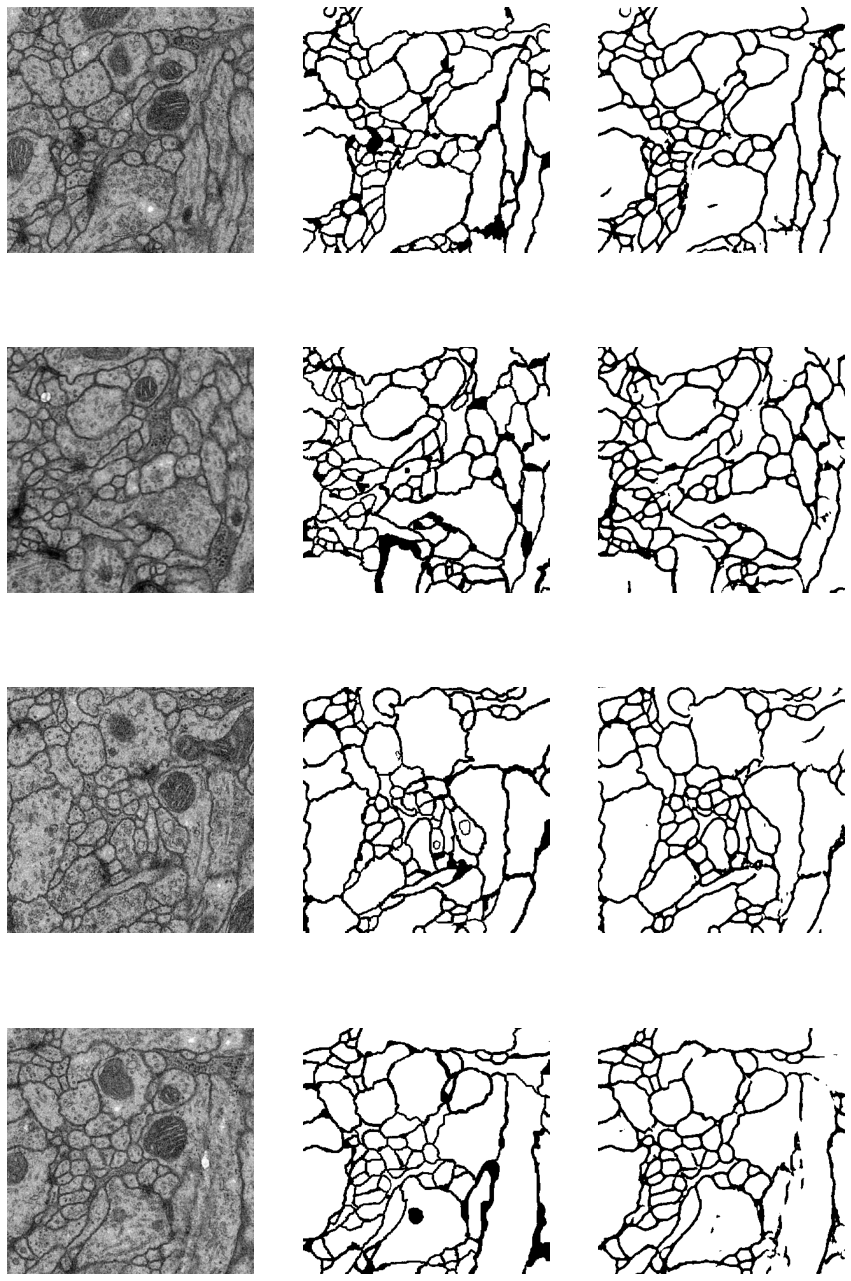

In [84]:
for inputs, labels in val_loader:                
        
    inputs=inputs.cuda()
    with torch.no_grad(): # Tell torch not to calculate gradients
        output = model.forward(inputs) # Forward pass
    
    # Add batch sample into 
    inputs = F.pad(inputs,(-92,-92,-92,-92)) ##
    input_img = inputs.cpu().numpy()
    gt = labels.cpu().numpy()
    pred = output.data.cpu().numpy()
    pred = np.argmax(pred, axis=1)
    visualize(input_img, gt, pred)